<a href="https://colab.research.google.com/github/Renu1302-tech/Twitter_Sentimental_Analysis/blob/master/Twitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv2D, MaxPooling2D, Dropout, Flatten, Bidirectional
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Twitter Sentimental Analysis/Twitter_Dataset.csv', encoding='ISO-8859-1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Since This dataset does not contain header, pandas are taking the 1st row as header, so we are explicitly specifying the column name

In [ ]:
column_name = ['sentiment_label', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('/content/drive/MyDrive/Twitter Sentimental Analysis/Twitter_Dataset.csv', encoding='ISO-8859-1', names=column_name)
df.head()

,sentiment_label,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment_label  1600000 non-null  int64 
 1   ids              1600000 non-null  int64 
 2   date             1600000 non-null  object
 3   flag             1600000 non-null  object
 4   user             1600000 non-null  object
 5   text             1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df['sentiment_label'].value_counts()

,count
sentiment_label,
0,800000
4,800000


## Clean the text

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtag
    text = re.sub(r'#\w+', '', text)
    #Remove Username
    text = re.sub(r'@\w+', '', text)
    #Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #numbers
    text = re.sub(r'\d+', '', text)

    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['text_length'] = df['text'].apply(len)

In [ ]:
df[['text','clean_text']].sample(5)

,text,clean_text
859364,Naw I should go home as I don't like to go out...,naw i should go home as i dont like to go out ...
425456,Well I've finished the work I wanted to get do...,well ive finished the work i wanted to get don...
1398919,I've finally re-joined the ranks of the workin...,ive finally rejoined the ranks of the working ...
357837,**STUFFED** Ate 1000 sushi rolls too many for ...,stuffed ate sushi rolls too many for lunch
843562,@apreezyl wrong! but might as well be his birt...,wrong but might as well be his birthday


## Lemmatize the clean text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = (stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_and_remove_stopwords(clean_text):
    # Tokenize text
    words = clean_text.split()
    # Lemmatize and remove stopwords
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(lemmatized_words)

df['lemmatized_text'] = df['clean_text'].apply(lemmatize_and_remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df[['text','clean_text','lemmatized_text']].sample(5)

,text,clean_text,lemmatized_text
641198,#inaperfectworld i'd understand the reason why...,id understand the reason why people act and re...,id understand reason people act react many thi...
834584,"@chhophyel Nadal Haha , but Djokovic is leadi...",nadal haha but djokovic is leading in the se...,nadal haha djokovic leading second set nadal t...
845858,Lunch @ T5 with a nice view http://twitpic.c...,lunch t with a nice view,lunch nice view
1539657,"@mileycyrus Hey Miley, how did the first day o...",hey miley how did the first day of shooting yo...,hey miley first day shooting new movie go hope...
639412,@branditopolis i miss you ......................,i miss you was that too gay,miss gay


In [ ]:
df.columns

Index(['sentiment_label', 'ids', 'date', 'flag', 'user', 'text', 'clean_text',
       'text_length', 'lemmatized_text'],
      dtype='object')

In [ ]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment_label  1600000 non-null  int64 
 1   text             1600000 non-null  object
 2   clean_text       1600000 non-null  object
 3   text_length      1600000 non-null  int64 
 4   lemmatized_text  1600000 non-null  object
dtypes: int64(2), object(3)
memory usage: 61.0+ MB


## since we have 0:negative, 4:positive -> 0:negative, 1:positive

In [ ]:
df['sentiment_label'] = df['sentiment_label'].map({0: 0, 4: 1})

## EDA

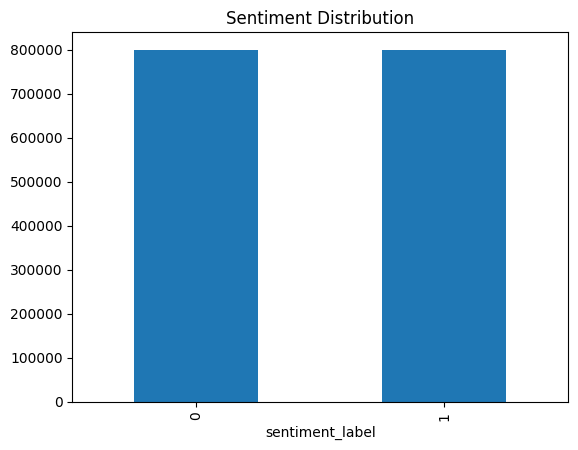

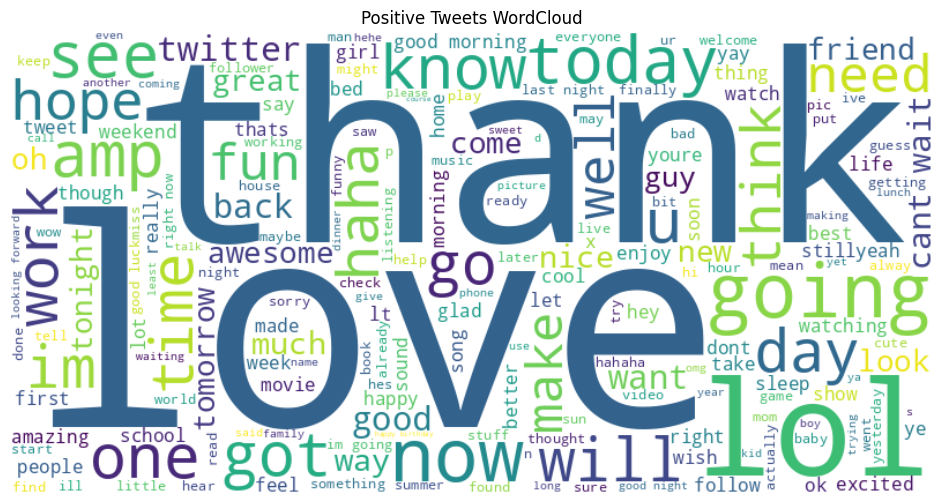

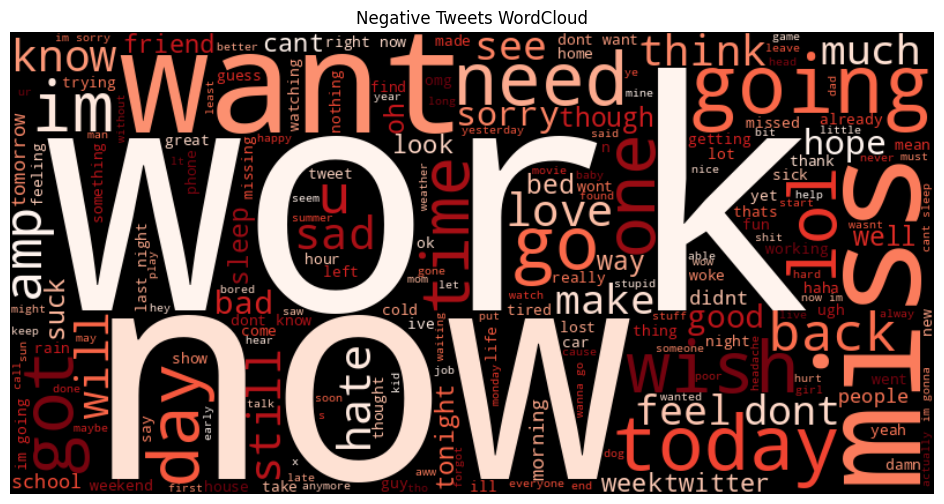

In [ ]:
# Plot class distribution
df['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

# WordCloud for positive and negative tweets
positive_text = ' '.join(df[df['sentiment_label'] == 1]['clean_text'])
negative_text = ' '.join(df[df['sentiment_label'] == 0]['clean_text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets WordCloud')
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Tweets WordCloud')
plt.show()

## Vectorization

In [ ]:
# Vectorize the lemmatized text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['lemmatized_text'])

# Target variable
Y = df['sentiment_label']

print(f"TF-IDF matrix shape: {X.shape}")

TF-IDF matrix shape: (1600000, 5000)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model 1- Logistic Regression

In [ ]:
log_df = LogisticRegression(max_iter=200)
log_df.fit(X_train, Y_train)
Y_pred_log = log_df.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(Y_test, Y_pred_log))

# Print overall (macro) recall
overall_recall_log = recall_score(Y_test, Y_pred_log, average='macro')  # or 'weighted'
print("Macro Recall:", overall_recall_log)

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_test, Y_pred_log, average=None))

print("F1 Score (Test):", f1_score(Y_test, Y_pred_log))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

Macro Recall: 0.7735146398669661
Recall for each class (0, 1):
[0.751464   0.79556527]
F1 Score (Test): 0.7789982277886401


In [ ]:
log_df = LogisticRegression(max_iter=200)
log_df.fit(X_train, Y_train)
Y_train_pred_log = log_df.predict(X_train)

print("Logistic Regression Report:")
print(classification_report(Y_train, Y_train_pred_log))

# Print overall (macro) recall
overall_recall_log = recall_score(Y_train, Y_train_pred_log, average='macro')  # or 'weighted'
print("Macro Recall:", overall_recall_log)

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_train, Y_train_pred_log, average=None))

print("F1 Score (Train):", f1_score(Y_train, Y_train_pred_log))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    640506
           1       0.76      0.80      0.78    639494

    accuracy                           0.78   1280000
   macro avg       0.78      0.78      0.78   1280000
weighted avg       0.78      0.78      0.78   1280000

Macro Recall: 0.7765835460750605
Recall for each class (0, 1):
[0.75490472 0.79826238]
F1 Score (Train): 0.7811759016896423


### Here this model is balanced

## Model 2- SVM

In [ ]:
svm = LinearSVC()
svm.fit(X_train, Y_train)
Y_pred_svm = svm.predict(X_test)

print("SVM Report:")
print(classification_report(Y_test, Y_pred_svm))

#print overall recall
overall_recall_svm = recall_score(Y_test,Y_pred_svm)
print("SVM Recall", overall_recall_svm)

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_test, Y_pred_svm, average=None))

print("F1 Score (Test):", f1_score(Y_test, Y_pred_svm))

SVM Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

SVM Recall 0.7988486411722926
Recall for each class (0, 1):
[0.74673028 0.79884864]
F1 Score (Test): 0.7791663248470927


In [ ]:
svm = LinearSVC()
svm.fit(X_train, Y_train)
Y_train_pred_svm = svm.predict(X_train)

print("SVM Report:")
print(classification_report(Y_train, Y_train_pred_svm))

#print overall recall
overall_recall_svm = recall_score(Y_train,Y_train_pred_svm)
print("SVM Recall", overall_recall_svm)

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_train, Y_train_pred_svm, average=None))

print("F1 Score (Train):", f1_score(Y_train, Y_train_pred_svm))

SVM Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    640506
           1       0.76      0.80      0.78    639494

    accuracy                           0.78   1280000
   macro avg       0.78      0.78      0.78   1280000
weighted avg       0.78      0.78      0.78   1280000

SVM Recall 0.8019105730468151
Recall for each class (0, 1):
[0.7499477  0.80191057]
F1 Score (Train): 0.7814526949547838


### MODEL 3 XG BOOST

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
Y_pred_xgb = svm.predict(X_test)

print("SVM Report:")
print(classification_report(Y_test, Y_pred_xgb))

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_test, Y_pred_xgb, average=None))

print("F1 Score (Test):", f1_score(Y_test, Y_pred_xgb))

SVM Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

Recall for each class (0, 1):
[0.74673028 0.79884864]
F1 Score (Test): 0.7791663248470927


In [ ]:
Y_pred_xgb = svm.predict(X_train)

print("SVM Report:")
print(classification_report(Y_train, Y_pred_xgb))

# You can also print recall for each class:
print("Recall for each class (0, 1):")
print(recall_score(Y_train, Y_pred_xgb, average=None))

print("F1 Score (train):", f1_score(Y_train, Y_pred_xgb))

SVM Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    640506
           1       0.76      0.80      0.78    639494

    accuracy                           0.78   1280000
   macro avg       0.78      0.78      0.78   1280000
weighted avg       0.78      0.78      0.78   1280000

Recall for each class (0, 1):
[0.7499477  0.80191057]
F1 Score (train): 0.7814526949547838


### Since we have all the models balanced and now we are trying to improve it by hyperparameter tuning

## Hyperparameter Tuning

### LOGISTIC REGRESSION

In [ ]:
lr_perform = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

In [ ]:
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_perform, scoring = 'f1', cv=5, n_jobs=-1)

In [ ]:
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_perform, scoring = 'f1', cv=5, n_jobs=-1)

In [ ]:
grid_lr.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [ ]:
best_log_model = grid_lr.best_estimator_

In [ ]:
print("✅ Best Logistic Regression Params:", grid_lr.best_params_)

✅ Best Logistic Regression Params: {'C': 1, 'solver': 'liblinear'}


In [ ]:
Y_grid_lr = best_log_model.predict(X_test)
print("\n📊 Logistic Regression (Tuned) on Test Set:")
print(classification_report(Y_test, Y_grid_lr))
print("F1 Score (Test):", f1_score(Y_test, Y_grid_lr))


📊 Logistic Regression (Tuned) on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

F1 Score (Test): 0.7789055564199485


In [ ]:
Y_pred_log_train = best_log_model.predict(X_train)

# F1 Score on training data
f1_train = f1_score(Y_train, Y_pred_log_train)
print("F1 Score (Train):", f1_train)

F1 Score (Train): 0.781317933794942


### SVM

In [ ]:
svm_perfom = {
    'C': [0.01, 0.1, 1, 10]
}

In [ ]:
svm_grid = GridSearchCV(LinearSVC(), svm_perfom, scoring='f1', cv=3, n_jobs=-1)
svm_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='f1')

In [ ]:
best_svm_model = svm_grid.best_estimator_
print("\n✅ Best SVM Params:", svm_grid.best_params_)


✅ Best SVM Params: {'C': 0.1}


In [ ]:
Y_svm_grid = best_svm_model.predict(X_test)
print("\n📊 SVM (Tuned) on Test Set:")
print(classification_report(Y_test, Y_svm_grid))
print("F1 Score (Test):", f1_score(Y_test, Y_svm_grid))


📊 SVM (Tuned) on Test Set:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

F1 Score (Test): 0.7790230068482533


In [ ]:
Y_pred_svm_train = best_svm_model.predict(X_train)

# F1 Score on training data
f1_train = f1_score(Y_train, Y_pred_svm_train)
print("F1 Score (Train):", f1_train)

F1 Score (Train): 0.78132075040211


### LSTM

In [ ]:
tweets=df['lemmatized_text']
labels=df['sentiment_label']

In [ ]:
max_words = 30000
max_length = 100
embeded_dim = 100

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token='<00V>')
tokenizer.fit_on_texts(tweets)

sequences = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
from tensorflow.keras.layers import Reshape

def lstm_model(max_words, embeded_dim):
    K.clear_session()
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_words, embeded_dim))  # remove deprecated input_length
    model_lstm.add(Reshape((max_length, embeded_dim, 1)))  # add channel dimension
    model_lstm.add(Conv2D(filters=32, kernel_size=(3, embeded_dim), padding='same', activation='relu'))
    model_lstm.add(MaxPooling2D(pool_size=(2, 1)))
    model_lstm.add(Flatten())
    model_lstm.add(Dense(100, activation='relu'))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(2, activation='softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm

In [ ]:
# 1. One-hot encode the labels (required for categorical_crossentropy)
labels_cat = to_categorical(labels)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels_cat, test_size=0.2, random_state=42)

# 3. Build model
model = lstm_model(max_words=max_words, embeded_dim=embeded_dim)

# 4. Train model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=128, verbose=1)

# 5. Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 6. Evaluate
print("📊 LSTM Classification Report:")
print(classification_report(y_true, y_pred))
print("F1 Score (Test):", f1_score(y_true, y_pred))

Epoch 1/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 268s 29ms/step - accuracy: 0.7570 - loss: 0.5041 - val_accuracy: 0.7889 - val_loss: 0.4497
Epoch 2/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 261s 29ms/step - accuracy: 0.8008 - loss: 0.4362 - val_accuracy: 0.7957 - val_loss: 0.4398
Epoch 3/3
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 261s 29ms/step - accuracy: 0.8170 - loss: 0.4045 - val_accuracy: 0.7938 - val_loss: 0.4498
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
📊 LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79    159494
           1       0.78      0.82      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.80      0.79      0.79    320000
weighted avg       0.80      0.79      0.79    320000

F1 Score (Test): 0.7995366065576269
